In [19]:
import sys
# Reconfigure stdout to use UTF-8 encoding (fixes UnicodeEncodeError on Windows)

import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # For formatting x-axis with years

import tensorflow as tf
from keras.api.models import Sequential
from keras.api.layers import *
from keras.api.optimizers import Adam
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping



In [20]:
def create_sequences(X, y, dates, time_steps):
    X_seq, y_seq, date_seq = [], [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
        date_seq.append(dates[i + time_steps])  # Store corresponding date
    return np.array(X_seq), np.array(y_seq), np.array(date_seq)

def load_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end, auto_adjust=False)

    if data.empty:
        print(f"Error: No data retrieved for {ticker}. Check API availability.")
        sys.exit(1)  # Stop the script if data is missing

    data.reset_index(inplace=True)
    return data


In [21]:
def run_model(ticker, start, end):
    data = load_data(ticker, start, end)

    # Create target as next day's Adjusted Close price
    data['Target'] = data['Adj Close'].shift(-1)

    # Drop missing values
    data.dropna(inplace=True)


    # 2. Select Features and Prepare Target

    features = ['Volume', 'High', 'Low', 'Open', 'Close']
    X_raw = data[features].values


    y_raw = data['Target'].values.reshape(-1, 1)

    # Convert `Date` column to datetime format for plotting
    data['Date'] = pd.to_datetime(data['Date'])


    # 3. Normalize Features and Target

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X_raw)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_raw)


    time_steps = 90
    X_seq, y_seq, dates_seq = create_sequences(X_scaled, y_scaled, data['Date'].values, time_steps)


    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
        X_seq, y_seq, dates_seq, test_size=0.2, random_state=42, shuffle=False
    )


    model = Sequential([
      Input(shape=(time_steps, len(features))),
      LSTM(64, return_sequences=True, activation='tanh'),
      LSTM(32, return_sequences=False, activation='tanh'),
      Dropout(0.2),
      Dense(1)
    ])


    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Early Stopping callback (stops training if validation loss doesn’t improve for 20 epochs)
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

    # Training parameters
    epochs = 100
    batch_size = 32


    history = model.fit(
      X_train, y_train,
      epochs=epochs,
      batch_size=batch_size,
      validation_data=(X_test, y_test),
      verbose=1,
      callbacks=[early_stop]
    )


    y_pred = model.predict(X_test)

    # Directly inverse transform predictions & true values
    y_pred_actual = scaler_y.inverse_transform(y_pred)
    y_test_actual = scaler_y.inverse_transform(y_test)

    # Compute MAE on the actual price scale
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    mae_percentage = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

    return dates_test, y_test_actual, y_pred_actual, mae_percentage, rmse


In [22]:
def run_trading_strategy(y_pred_actual, y_test_actual, threshold=0.005, initial_capital=1000):
    """
    Executes a long/short trading strategy based on predicted vs. actual prices,
    only trading when the predicted change exceeds the specified threshold.

    Parameters:
        y_pred_actual (np.ndarray): Model's predicted prices (scaled back).
        y_test_actual (np.ndarray): Actual prices (scaled back).
        threshold (float): Minimum predicted change to trigger a trade (default: 0.005 = 0.5%).
        initial_capital (float): Starting capital (default: $1000).

    Returns:
        portfolio (list): Capital progression over time.
        final_return (float): Percentage return on the strategy.
        accuracy (float): Correct trend prediction accuracy.
        total_trades (int): Total number of trades made.
    """
    capital = initial_capital
    portfolio = []
    correct_trend_preds = 0
    total_trades = 0

    for i in range(1, len(y_pred_actual)):
        pred_today = y_pred_actual[i - 1][0]
        pred_tomorrow = y_pred_actual[i][0]
        price_today = y_test_actual[i - 1][0]
        price_tomorrow = y_test_actual[i][0]

        predicted_change = (pred_tomorrow - pred_today) / pred_today

        if abs(predicted_change) >= threshold:
            trade_amount = capital

            if predicted_change > 0:
                # Long position
                shares = trade_amount / price_today
                capital = shares * price_tomorrow

                if price_tomorrow > price_today:
                    correct_trend_preds += 1

            else:
                # Short position
                shares = trade_amount / price_today
                capital += (price_today - price_tomorrow) * shares

                if price_tomorrow < price_today:
                    correct_trend_preds += 1

            total_trades += 1

        portfolio.append(capital)

    final_return = (capital - initial_capital) / initial_capital * 100
    accuracy = (correct_trend_preds / total_trades * 100) if total_trades else 0

    return portfolio, final_return, accuracy, total_trades

In [23]:
# Run the model
ticker = "^GSPC"
TRAIN_START = "2015-01-01"
TRAIN_END = "2025-01-01"

dates_test, y_test_actual, y_pred_actual, mae_percentage1, rmse1 = run_model(ticker, TRAIN_START, TRAIN_END)


[*********************100%***********************]  1 of 1 completed

Epoch 1/100


61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0212 - val_loss: 0.0025
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0013 - val_loss: 7.3539e-04
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0013 - val_loss: 8.8196e-04
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


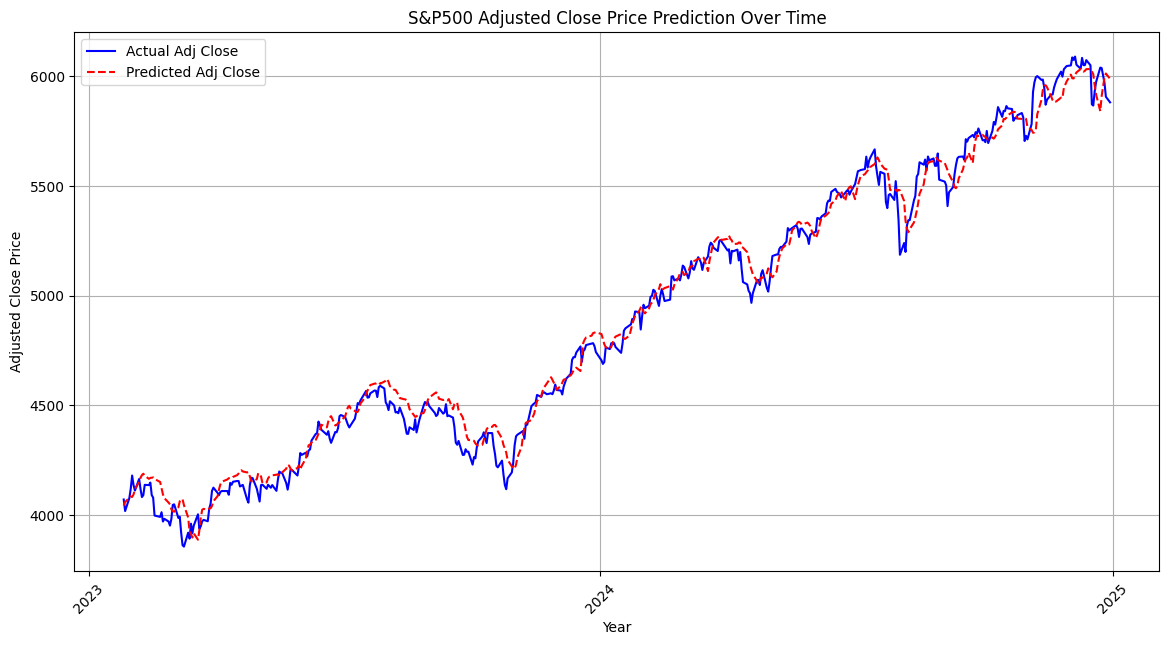

🔹 Mean Absolute Percentage Error : 0.011955941365792264
🔹Root Mean Squared Error (RMSE): 73.58033069125278


In [24]:

#  Plot Predictions Outside Function
plt.figure(figsize=(14, 7))

# Plot actual prices
plt.plot(dates_test, y_test_actual, label="Actual Adj Close", color="blue")

# Plot predicted prices
plt.plot(dates_test, y_pred_actual, label="Predicted Adj Close", color="red", linestyle="dashed")

# Format x-axis to show years instead of individual days
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show major ticks at each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year only
plt.xticks(rotation=45)  # Rotate labels for readability

plt.xlabel("Year")
plt.ylabel("Adjusted Close Price")
plt.title("S&P500 Adjusted Close Price Prediction Over Time")
plt.legend()
plt.grid()
plt.show()


# Print evaluation metrics
print(f" Mean Absolute Percentage Error : {mae_percentage1}")
print(f"Root Mean Squared Error (RMSE): {rmse1}")



 Final Return: -9.60%
 Accuracy: 52.63%
 Trades Made: 114


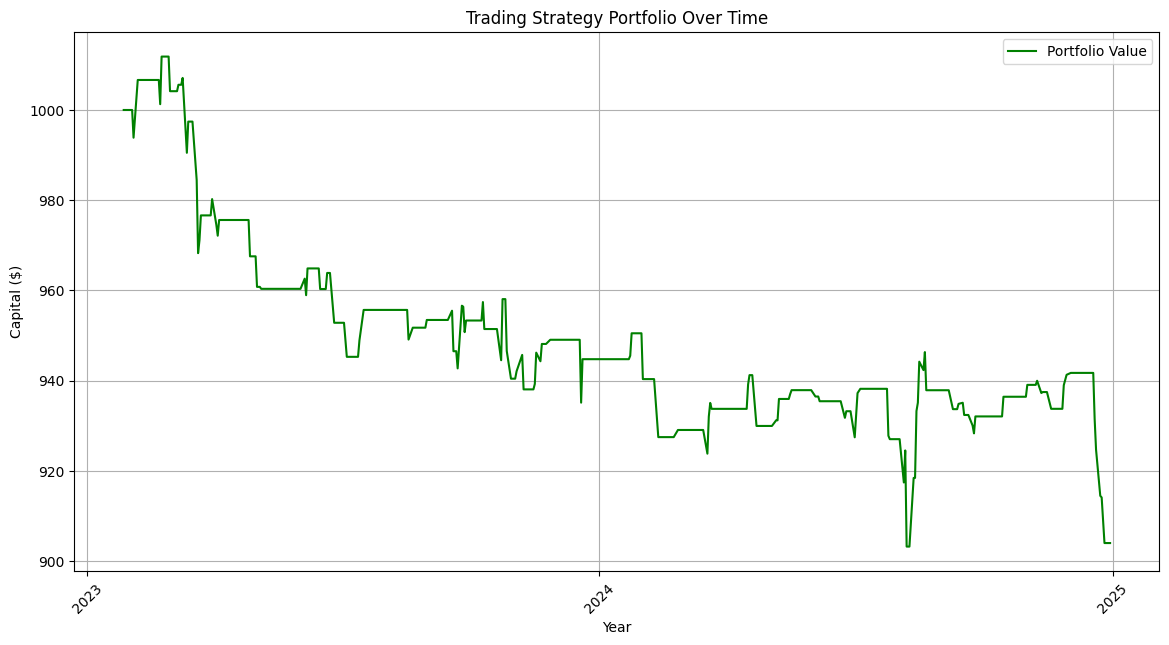

In [25]:
#dates_test, y_test_actual, y_pred_actual, mae_percentage1, rmse1 = run_model(ticker, TRAIN_START, TRAIN_END)

portfolio, final_return, accuracy, trades = run_trading_strategy(y_pred_actual, y_test_actual)

print(f" Final Return: {final_return:.2f}%")
print(f" Accuracy: {accuracy:.2f}%")
print(f" Trades Made: {trades}")

plt.figure(figsize=(14, 7))
portfolio_padded = np.insert(portfolio, 0, np.nan)  # or 100.0 as starting capital
plt.plot(dates_test, portfolio_padded, label="Portfolio Value", color="green")

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title("Trading Strategy Portfolio Over Time")
plt.xlabel("Year")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.show()


In [26]:
# Run the model
ticker = "^GSPC"
TRAIN_START = "2020-01-01"
TRAIN_END = "2025-01-01"

dates_test2, y_test_actual2, y_pred_actual2, mae_percentage2, rmse2 = run_model(ticker, TRAIN_START, TRAIN_END)


[*********************100%***********************]  1 of 1 completed

Epoch 1/100


30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.0774 - val_loss: 0.0080
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0060 - val_loss: 0.0123
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0041 - val_loss: 0.0097
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0032 - val_loss: 0.0086
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0037 - val_loss: 0.0059
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0032 - val_loss: 0.0062
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0031 - val_loss: 0.0051
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 

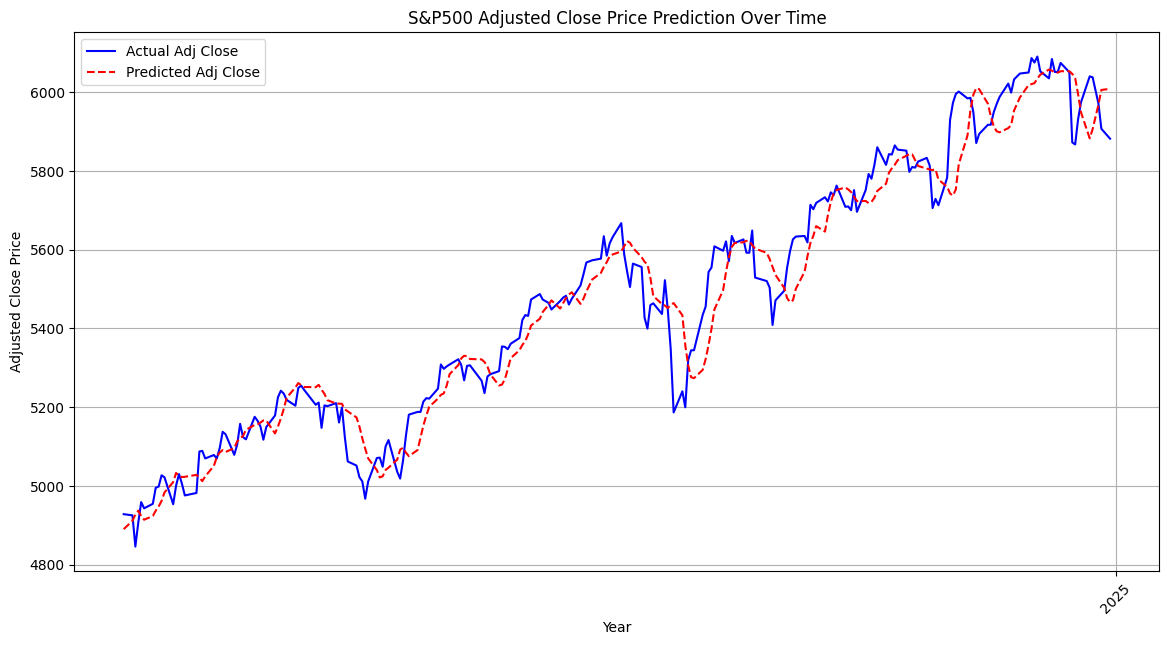

 Mean Absolute Percentage Error: 0.010603113916370486
 Root Mean Squared Error (RMSE): 75.7280986575564


In [27]:
plt.figure(figsize=(14, 7))

# Plot actual prices
plt.plot(dates_test2, y_test_actual2, label="Actual Adj Close", color="blue")

# Plot predicted prices
plt.plot(dates_test2, y_pred_actual2, label="Predicted Adj Close", color="red", linestyle="dashed")

# Format x-axis to show years instead of individual days
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show major ticks at each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year only
plt.xticks(rotation=45)  # Rotate labels for readability

plt.xlabel("Year")
plt.ylabel("Adjusted Close Price")
plt.title("S&P500 Adjusted Close Price Prediction Over Time")
plt.legend()
plt.grid()
plt.show()


# Print evaluation metrics
print(f"  Mean Absolute Percentage Error: {mae_percentage2}")
print(f" Root Mean Squared Error (RMSE): {rmse2}")



 Final Return: -7.88%
 Accuracy: 44.90%
 Trades Made: 49


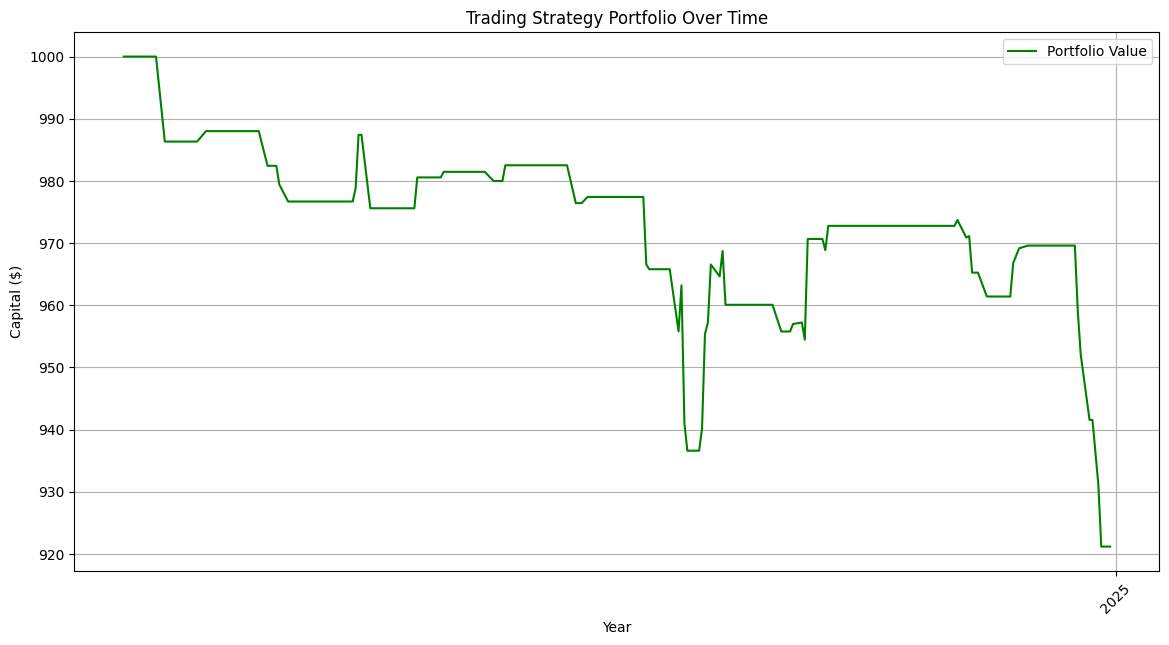

In [35]:
#dates_test, y_test_actual, y_pred_actual, mae_percentage1, rmse1 = run_model(ticker, TRAIN_START, TRAIN_END)

portfolio, final_return, accuracy, trades = run_trading_strategy(y_pred_actual2, y_test_actual2)

print(f" Final Return: {final_return:.2f}%")
print(f" Accuracy: {accuracy:.2f}%")
print(f" Trades Made: {trades}")

plt.figure(figsize=(14, 7))
portfolio_padded = np.insert(portfolio, 0, np.nan)  # or 100.0 as starting capital
plt.plot(dates_test2, portfolio_padded, label="Portfolio Value", color="green")

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title("Trading Strategy Portfolio Over Time")
plt.xlabel("Year")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.show()


In [29]:
# Run the model
ticker = "^GSPC"
TRAIN_START = "2005-01-01"
TRAIN_END = "2025-01-01"

dates_test3, y_test_actual3, y_pred_actual3, mae_percentage3, rmse3 = run_model(ticker, TRAIN_START, TRAIN_END)


[*********************100%***********************]  1 of 1 completed


Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - loss: 0.0117 - val_loss: 3.9030e-04
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 7.2495e-04 - val_loss: 0.0014
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 5.8404e-04 - val_loss: 9.7614e-04
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 5.9337e-04 - val_loss: 3.7501e-04
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 5.2102e-04 - val_loss: 0.0015
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 5.3194e-04 - val_loss: 3.5024e-04
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 4.4789e-04 - val_loss: 3.8117e-04
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 4.5693e-04 - val_loss: 8.7828e-04
Epoch 9/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 4.2102e-04 - val_loss: 0.0023
Epoch 10/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 3.8664e-04 - val_loss: 0.0023
Epoch 11/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/s

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


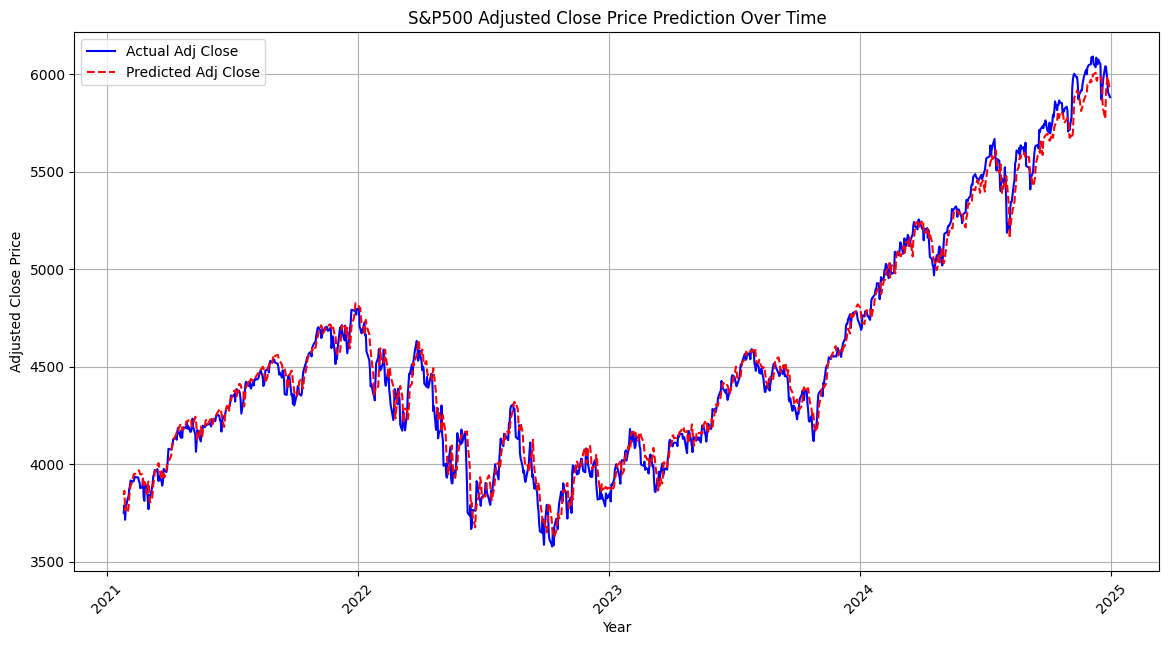

 Mean Absolute Percentage Error: 0.012683618355322897
 Root Mean Squared Error (RMSE): 73.49139176705053


In [30]:
plt.figure(figsize=(14, 7))

# Plot actual prices
plt.plot(dates_test3, y_test_actual3, label="Actual Adj Close", color="blue")

# Plot predicted prices
plt.plot(dates_test3, y_pred_actual3, label="Predicted Adj Close", color="red", linestyle="dashed")

# Format x-axis to show years instead of individual days
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show major ticks at each year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year only
plt.xticks(rotation=45)  # Rotate labels for readability

plt.xlabel("Year")
plt.ylabel("Adjusted Close Price")
plt.title("S&P500 Adjusted Close Price Prediction Over Time")
plt.legend()
plt.grid()
plt.show()


# Print evaluation metrics
print(f" Mean Absolute Percentage Error: {mae_percentage3}")
print(f" Root Mean Squared Error (RMSE): {rmse3}")


 Final Return: -34.57%
 Accuracy: 50.86%
 Trades Made: 466


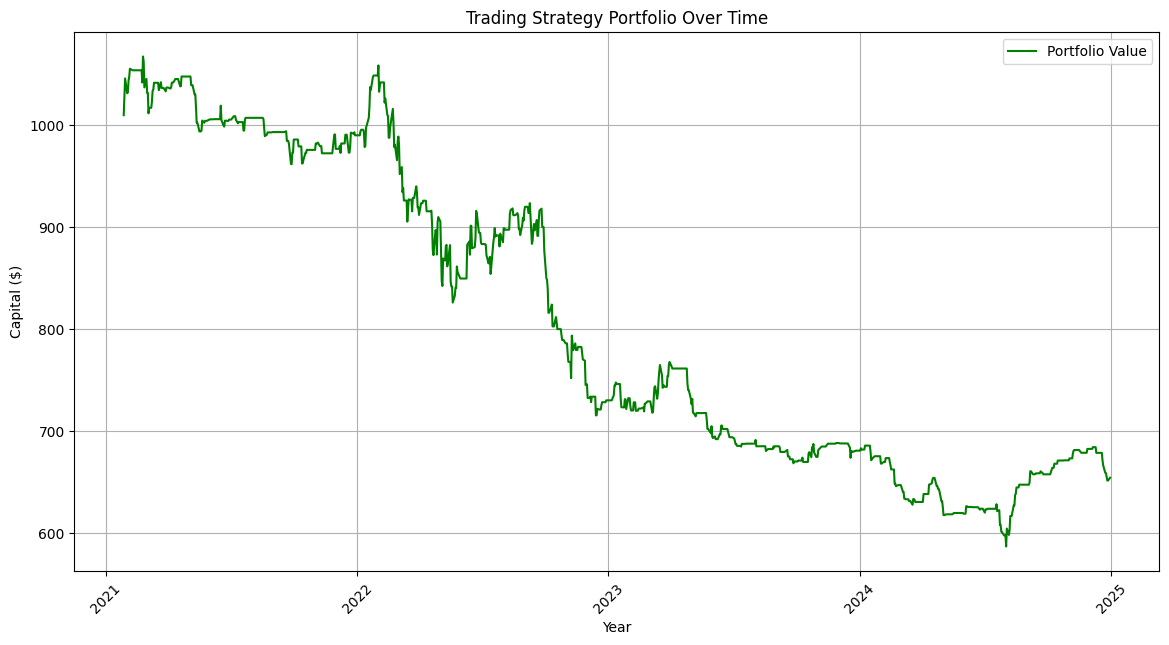

In [36]:
#dates_test, y_test_actual, y_pred_actual, mae_percentage1, rmse1 = run_model(ticker, TRAIN_START, TRAIN_END)

portfolio, final_return, accuracy, trades = run_trading_strategy(y_pred_actual3, y_test_actual3)

print(f" Final Return: {final_return:.2f}%")
print(f" Accuracy: {accuracy:.2f}%")
print(f" Trades Made: {trades}")

plt.figure(figsize=(14, 7))
portfolio_padded = np.insert(portfolio, 0, np.nan)  # or 100.0 as starting capital
plt.plot(dates_test3, portfolio_padded, label="Portfolio Value", color="green")

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.title("Trading Strategy Portfolio Over Time")
plt.xlabel("Year")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.legend()
plt.show()
